Using device: cpu
Epoch 0 | PDE loss: 2.1310e-03, BC loss: 5.4472e-01
Epoch 500 | PDE loss: 3.7945e-04, BC loss: 6.2496e-02
Epoch 1000 | PDE loss: 1.1328e-03, BC loss: 5.7805e-02
Epoch 1500 | PDE loss: 2.1110e-03, BC loss: 3.7268e-02
Epoch 2000 | PDE loss: 2.0513e-03, BC loss: 2.6704e-02
Epoch 2500 | PDE loss: 8.0168e-04, BC loss: 2.3802e-02
Epoch 3000 | PDE loss: 2.2917e-03, BC loss: 2.3036e-02
Epoch 3500 | PDE loss: 4.2727e-04, BC loss: 2.2473e-02
Epoch 4000 | PDE loss: 4.3792e-04, BC loss: 2.2039e-02
Epoch 4500 | PDE loss: 1.5079e-03, BC loss: 2.1668e-02
Epoch 5000 | PDE loss: 4.6609e-04, BC loss: 2.1242e-02
Epoch 5500 | PDE loss: 4.5943e-04, BC loss: 2.0832e-02
Epoch 6000 | PDE loss: 4.7297e-04, BC loss: 2.0423e-02
Epoch 6500 | PDE loss: 5.8448e-04, BC loss: 2.0006e-02
Epoch 7000 | PDE loss: 4.9163e-04, BC loss: 1.9566e-02
Epoch 7500 | PDE loss: 5.1839e-04, BC loss: 1.9136e-02
Epoch 8000 | PDE loss: 9.2133e-04, BC loss: 1.8757e-02
Epoch 8500 | PDE loss: 5.3116e-04, BC loss: 1.8432e

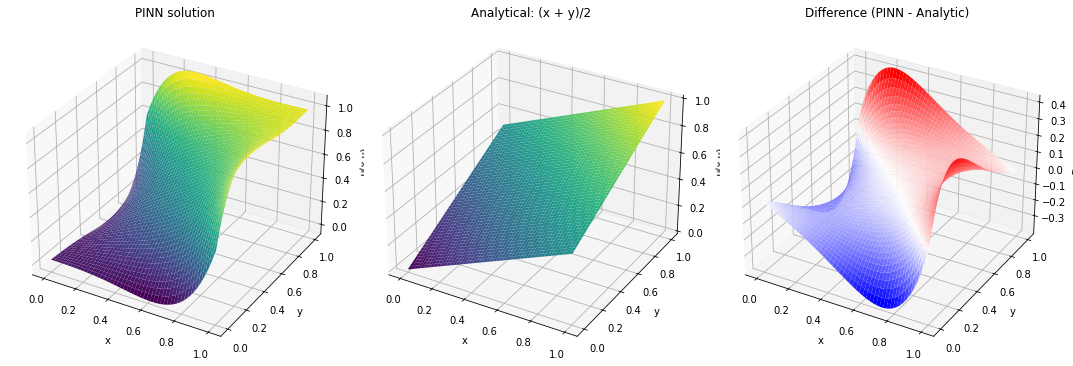

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title: 2D Laplace Equation with Non-Zero BCs using PINNs (3D Plot Version)

We solve:
    u_xx + u_yy = 0,   (x,y) in (0,1)x(0,1)
with boundary conditions:
    u(0,y) = 0,  u(1,y) = 1,  for y in [0,1]
    u(x,0) = 0,  u(x,1) = 1,  for x in [0,1]

Analytical solution (since it's linear from 0 to 1 on both edges):
    u(x,y) = (x + y)/2.

PINN approach:
    - A neural network u_theta(x,y).
    - PDE residual: u_xx + u_yy = 0 in the interior.
    - BC: matches the non-zero boundary values.

After training, we create three 3D subplots to visualize:
1) The PINN solution
2) The analytical solution
3) The difference
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class LaplaceNet(nn.Module):
    """
    Neural network that takes (x,y) as input and outputs scalar u(x,y).
    We'll use a few hidden layers with Tanh activation.
    """
    def __init__(self, hidden_units=256):
        super(LaplaceNet, self).__init__()
        self.layer1 = nn.Linear(2, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.layer3 = nn.Linear(hidden_units, 1)
        self.activation = nn.Tanh()

    def forward(self, xy):
        # xy shape: (N,2) => columns [x, y]
        out = self.activation(self.layer1(xy))
        out = self.activation(self.layer2(out))
        out = self.layer3(out)
        return out

def laplace_residual(model, x, y):
    """
    PDE residual: u_xx + u_yy = 0
    """
    # Enable gradients
    x.requires_grad_(True)
    y.requires_grad_(True)

    inp = torch.cat([x, y], dim=1)  # shape (N,2)
    u = model(inp)

    # First partial derivatives
    dudx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                               create_graph=True)[0]
    dudy = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),
                               create_graph=True)[0]

    # Second partial derivatives
    d2udx2 = torch.autograd.grad(dudx, x, grad_outputs=torch.ones_like(dudx),
                                 create_graph=True)[0]
    d2udy2 = torch.autograd.grad(dudy, y, grad_outputs=torch.ones_like(dudy),
                                 create_graph=True)[0]

    # Laplace PDE residual = u_xx + u_yy
    res = d2udx2 + d2udy2
    return res

def boundary_condition(x, y):
    """
    Return the exact boundary value for (x,y).

    Boundary rules:
      - x=0 => u=0
      - x=1 => u=1
      - y=0 => u=0
      - y=1 => u=1
    """
    bc_val = torch.zeros_like(x)  # default = 0
    tol = 1e-6

    # Right side x=1 => u=1
    mask_right = (x > 1.0 - tol)
    bc_val[mask_right] = 1.0

    # Top side y=1 => u=1
    mask_top = (y > 1.0 - tol)
    bc_val[mask_top] = 1.0

    return bc_val

def sample_boundary(N):
    """
    Sample boundary points on x=0, x=1, y=0, y=1
    Return a tensor of shape (4N, 2).
    """
    x_rand = torch.rand((N,1), device=device)
    y_rand = torch.rand((N,1), device=device)

    # top (y=1), bottom (y=0)
    top = torch.cat([x_rand, torch.ones_like(x_rand)], dim=1)
    bottom = torch.cat([x_rand, torch.zeros_like(x_rand)], dim=1)
    # left (x=0), right (x=1)
    left = torch.cat([torch.zeros_like(y_rand), y_rand], dim=1)
    right = torch.cat([torch.ones_like(y_rand), y_rand], dim=1)

    boundary = torch.cat([top, bottom, left, right], dim=0)
    return boundary

def main():
    model = LaplaceNet(hidden_units=30).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 5000

    # Interior collocation points
    N_interior = 1000
    xy_interior = torch.rand((N_interior, 2), device=device)
    x_in = xy_interior[:,0:1]
    y_in = xy_interior[:,1:2]

    # Boundary points
    boundary_xy = sample_boundary(200)

    # -------------------- Training Loop --------------------
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # PDE residual in interior
        res = laplace_residual(model, x_in, y_in)
        loss_pde = torch.mean(res**2)

        # Boundary condition
        x_b = boundary_xy[:,0:1]
        y_b = boundary_xy[:,1:2]
        u_b_pred = model(boundary_xy)
        u_b_true = boundary_condition(x_b, y_b)
        loss_bc = torch.mean((u_b_pred - u_b_true)**2)

        # Total loss
        loss = loss_pde + loss_bc
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | PDE loss: {loss_pde.item():.4e}, BC loss: {loss_bc.item():.4e}")

    # -------------------- Evaluation --------------------
    Nx, Ny = 50, 50
    x_space = torch.linspace(0,1,Nx, device=device)
    y_space = torch.linspace(0,1,Ny, device=device)
    XX, YY = torch.meshgrid(x_space, y_space, indexing='xy')  # shape: Nx x Ny

    # Flatten to evaluate PINN
    XY = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], dim=1)  # shape (Nx*Ny,2)
    u_pred = model(XY).detach().cpu().numpy().reshape(Nx, Ny)

    # Analytical solution
    x_np = XX.cpu().numpy()
    y_np = YY.cpu().numpy()
    u_true = 0.5*(x_np + y_np)

    # Compute difference
    diff = u_pred - u_true

    # ---------- 3D PLOTS ----------
    # Because 'indexing=xy', XX,YY have shape (Nx, Ny).
    # We'll do 3 subplots for 3D surfaces:
    # 1) PINN solution
    # 2) Analytical solution
    # 3) Difference

    # We'll transpose Nx x Ny -> Ny x Nx if needed, but we can also
    # pass them directly to plot_surface so long as shapes match.

    # Just ensure all shapes match => (Nx, Ny).
    # We'll keep it consistent: X_np, Y_np => (Nx,Ny), same as u_pred => (Nx,Ny).

    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(15,5))

    # Subplot 1: PINN solution
    ax1 = fig.add_subplot(1,3,1, projection='3d')
    ax1.plot_surface(x_np, y_np, u_pred, cmap='viridis')
    ax1.set_title("PINN solution")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("u(x,y)")

    # Subplot 2: Analytical solution
    ax2 = fig.add_subplot(1,3,2, projection='3d')
    ax2.plot_surface(x_np, y_np, u_true, cmap='viridis')
    ax2.set_title("Analytical: (x + y)/2")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")

    # Subplot 3: Difference
    ax3 = fig.add_subplot(1,3,3, projection='3d')
    ax3.plot_surface(x_np, y_np, diff, cmap='bwr')
    ax3.set_title("Difference (PINN - Analytic)")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_zlabel("Error")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
